## Note 
### If you really want to gain knowledge please Refer to version before 32 
### After version 32 i am not focusing on details but only on accuracy score
## feel free to ask Question

## Upvote my work if you like it

## Importing Libraries and Loading Dataset
Import essential libraries and load the Titanic dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

In [2]:
training_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
output_data=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

## Data Overview
Preview the first few rows of the datasets to understand their structure.

In [3]:
output_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [4]:
training_data.head()
training_data.shape

(891, 12)

In [5]:
test_data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## Visualisation of Relationship between Input and Output

<Axes: xlabel='Survived', ylabel='count'>

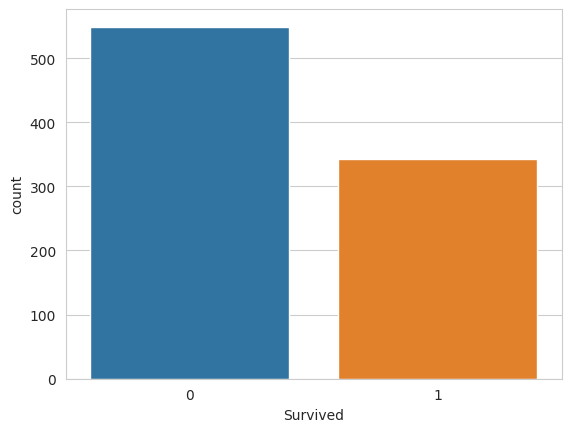

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=training_data)


In [7]:
filtered_data = training_data[~training_data['Embarked'].isin(['C', 'S', 'Q'])]
filtered_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


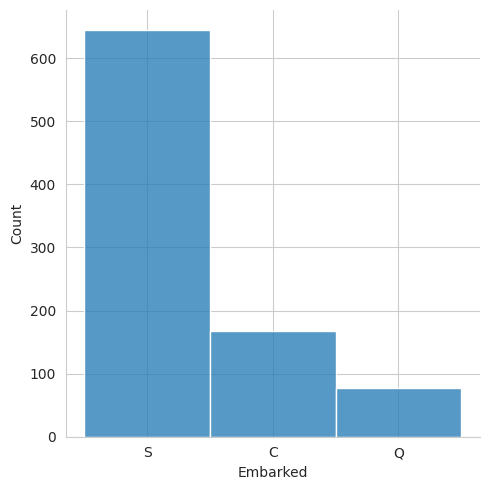

In [8]:
sns.displot(data=training_data,x='Embarked')

In [9]:
embarked_mode = training_data['Embarked'].mode()[0]
# Fill NaN values in 'Embarked' with the mode
training_data['Embarked'].fillna(embarked_mode, inplace=True)

<Axes: xlabel='Survived', ylabel='count'>

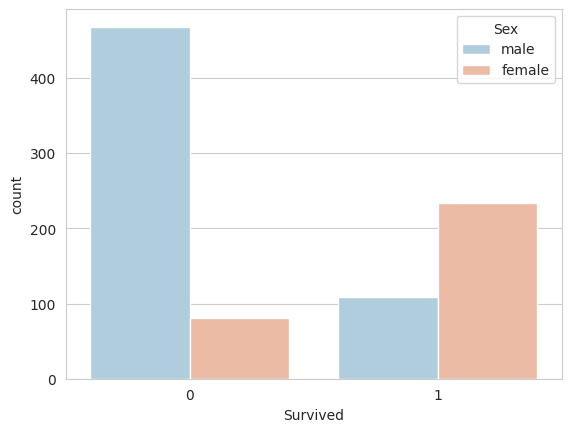

In [10]:
sns.countplot(x='Survived',data=training_data,hue='Sex',palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

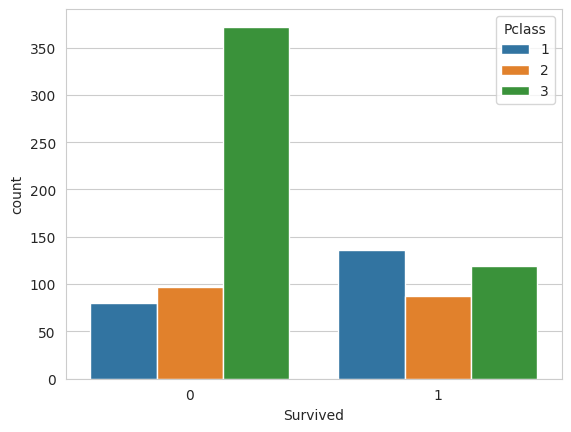

In [11]:
sns.countplot(x='Survived',data=training_data,hue='Pclass')

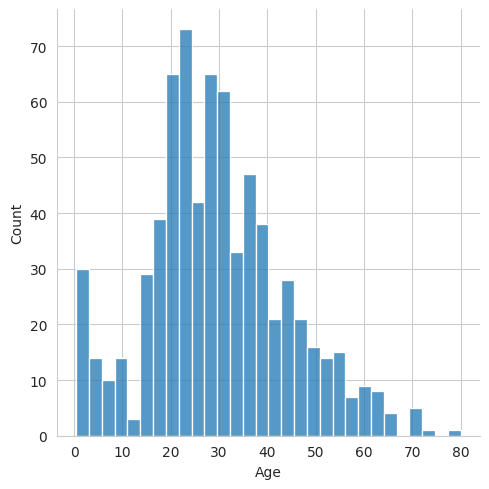

In [12]:
sns.displot(training_data['Age'],kde=False,bins=30)


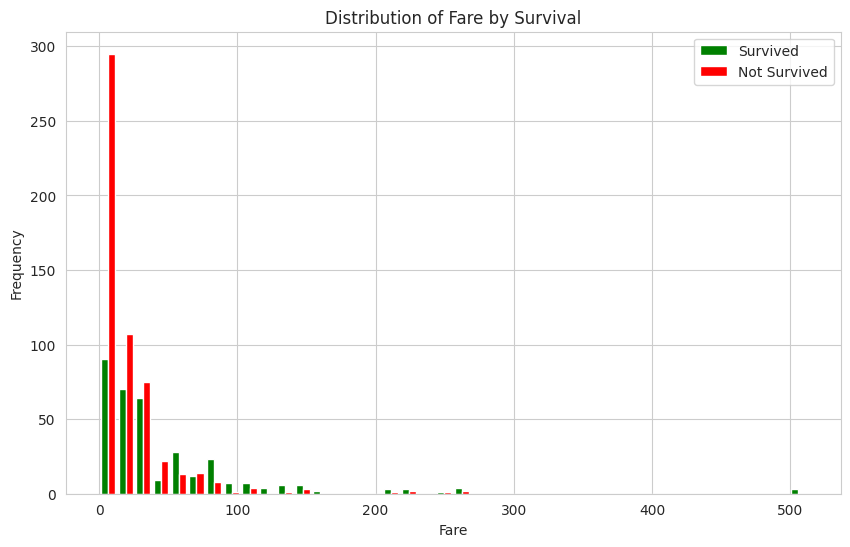

In [13]:
survived_fares = training_data[training_data['Survived'] == 1]['Fare']
not_survived_fares = training_data[training_data['Survived'] == 0]['Fare']

plt.figure(figsize=(10, 6))
plt.hist([survived_fares, not_survived_fares], bins=40, color=['green', 'red'], label=['Survived', 'Not Survived'])
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Distribution of Fare by Survival')
plt.legend()
plt.show()

<Axes: xlabel='SibSp', ylabel='count'>

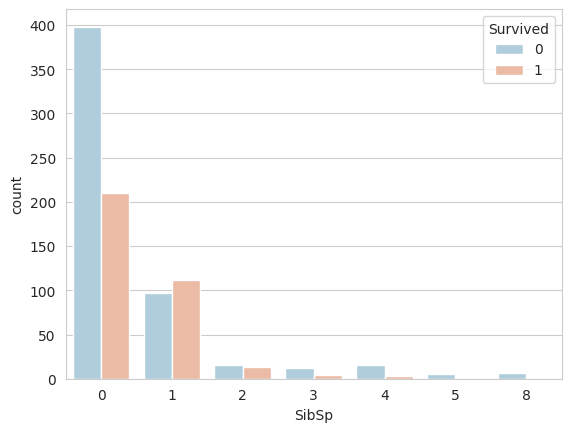

In [14]:
sns.countplot(x='SibSp',data=training_data,hue='Survived',palette='RdBu_r')

<Axes: xlabel='Parch', ylabel='count'>

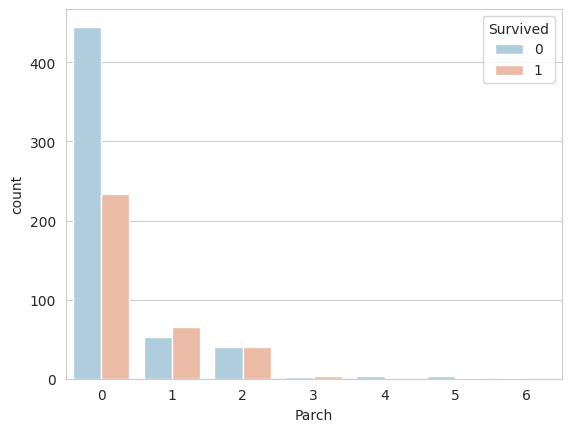

In [15]:
sns.countplot(x='Parch',data=training_data,hue='Survived',palette='RdBu_r')

## Data Cleaning and Preprocessing

### Checking for Nan Values 

<Axes: >

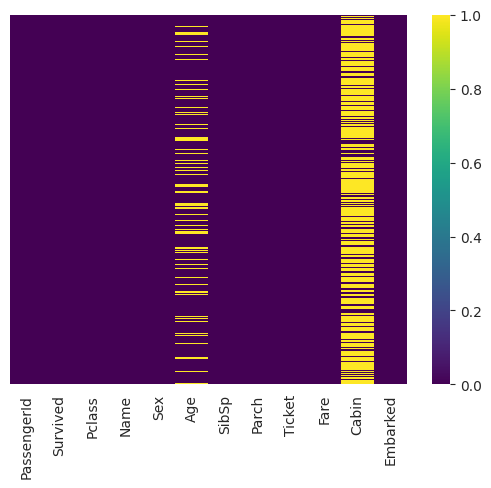

In [16]:
sns.heatmap(training_data.isnull(),yticklabels=False,cmap=('viridis'))

<Axes: >

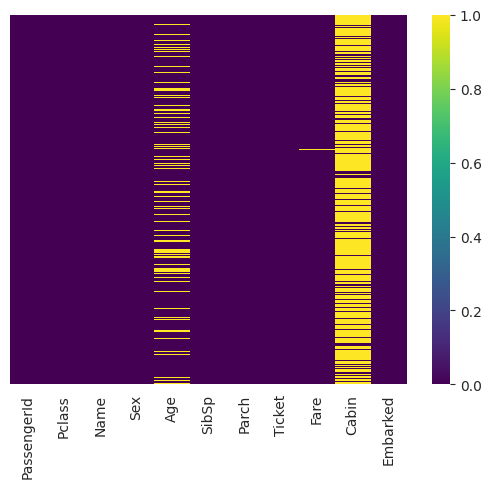

In [17]:
sns.heatmap(test_data.isnull(),yticklabels=False,cmap=('viridis'))

## Feature Engineering
Extract titles from passenger names and apply one-hot encoding.
Drop unnecessary columns.


### Purpose:

The below function preprocesses the Titanic dataset by extracting titles from passenger names and applying one-hot encoding to categorical features.
### What and Why:
- **Extract Titles**: Identifies social status, potentially affecting survival.
- **One-Hot Encoding**: Converts categorical variables ('Title', 'Embarked', 'Sex', 'Pclass') into numerical format suitable for machine learning models.
- **Drop Unnecessary Columns**: Removes original and irrelevant columns to clean the dataset.
- The result is a numerically encoded DataFrame ready for modeling.

In [18]:
def add_title_and_encode(data):
    # Extract titles using a raw string for the regex pattern
    data['Title'] = data.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
    data.Title = data.Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Title = data.Title.replace('Mlle', 'Miss')
    data.Title = data.Title.replace('Ms', 'Miss')
    data.Title = data.Title.replace('Mme', 'Mrs')
    
    # Apply OneHotEncoder to the 'Title' column
    encoder_title = OneHotEncoder(sparse_output=False, drop='first')
    title_encoded = encoder_title.fit_transform(data[['Title']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    title_encoded_df = pd.DataFrame(title_encoded, columns=encoder_title.get_feature_names_out(['Title'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, title_encoded_df], axis=1)
    
    # Drop the original 'Title' column
    data.drop('Title', axis=1, inplace=True)
    
    # Apply OneHotEncoder to the 'Embarked' column
    encoder_embarked = OneHotEncoder(sparse_output=False, drop='first')
    embarked_encoded = encoder_embarked.fit_transform(data[['Embarked']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=encoder_embarked.get_feature_names_out(['Embarked'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, embarked_encoded_df], axis=1)
    
    # Apply OneHotEncoder to the 'Sex' column
    encoder_Sex = OneHotEncoder(sparse_output=False, drop='first')
    Sex_encoded = encoder_Sex.fit_transform(data[['Sex']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    Sex_encoded_df = pd.DataFrame(Sex_encoded, columns=encoder_Sex.get_feature_names_out(['Sex'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns
    data = pd.concat([data, Sex_encoded_df], axis=1)
    
    # Apply OneHotEncoder to the 'Pclass' column
    encoder_Pclass = OneHotEncoder(sparse_output=False, drop='first')
    Pclass_encoded = encoder_Pclass.fit_transform(data[['Pclass']])
    
    # Create a DataFrame with the encoded columns and appropriate column names
    Pclass_encoded_df = pd.DataFrame(Pclass_encoded, columns=encoder_Pclass.get_feature_names_out(['Pclass'])).astype(int)
    
    # Concatenate the original data with the new one-hot-encoded columns for Pclass
    data = pd.concat([data, Pclass_encoded_df], axis=1)
    
    # Drop the original 'Sex', 'Pclass', 'Embarked', and other unnecessary columns
    data.drop(['Sex', 'Pclass', 'Embarked', 'Name', 'PassengerId','Cabin','Ticket','Age'], axis=1, inplace=True)
    
    return data


### New data fit for Modeling

In [19]:
training_data=add_title_and_encode(training_data)
test_data=add_title_and_encode(test_data)

In [20]:
test_data.head()

,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,0,7.8292,0,1,0,0,1,0,1,0,1
1,1,0,7.0000,0,0,1,0,0,1,0,0,1
2,0,0,9.6875,0,1,0,0,1,0,1,1,0
3,0,0,8.6625,0,1,0,0,0,1,1,0,1
4,1,1,12.2875,0,0,1,0,0,1,0,0,1


In [21]:
training_data.head()

,Survived,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,1,0,7.2500,0,1,0,0,0,1,1,0,1
1,1,1,0,71.2833,0,0,1,0,0,0,0,0,0
2,1,0,0,7.9250,1,0,0,0,0,1,0,0,1
3,1,1,0,53.1000,0,0,1,0,0,1,0,0,0
4,0,0,0,8.0500,0,1,0,0,0,1,1,0,1


## Filling NaN Values

In [22]:
test_data['Fare'] = test_data['Fare'].fillna(np.mean(test_data['Fare']))
training_data['Fare'] = training_data['Fare'].fillna(np.mean(training_data['Fare']))

<Axes: >

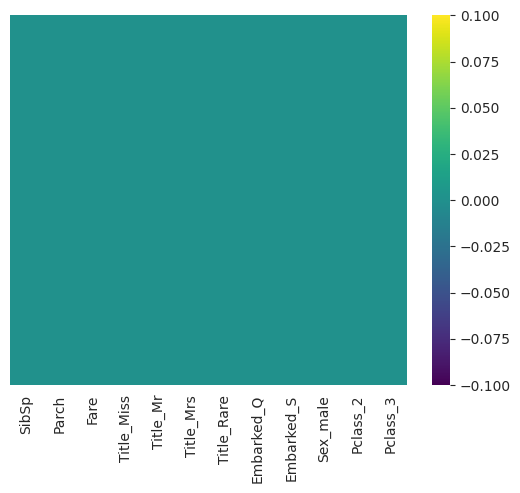

In [23]:
sns.heatmap(test_data.isnull(),yticklabels=False,cmap=('viridis'))

<Axes: >

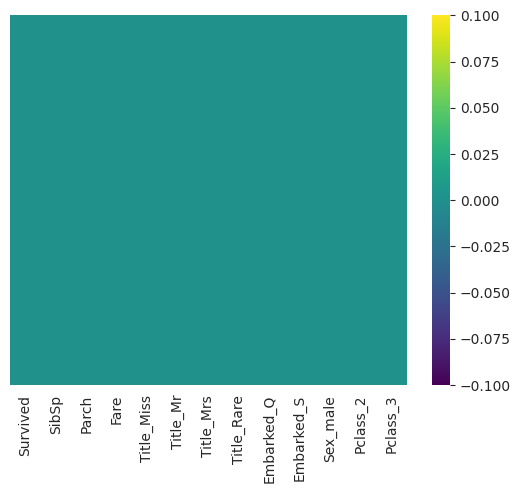

In [24]:
sns.heatmap(training_data.isnull(),yticklabels=False,cmap=('viridis'))

In [25]:
def add_features(data):
    # Family Size
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = 1
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0

    data['FarePerPerson'] = data['Fare'] / data['FamilySize']
    data.drop('Fare', axis=1, inplace=True)
    
    return data

training_data = add_features(training_data)
test_data = add_features(test_data)

<Axes: >

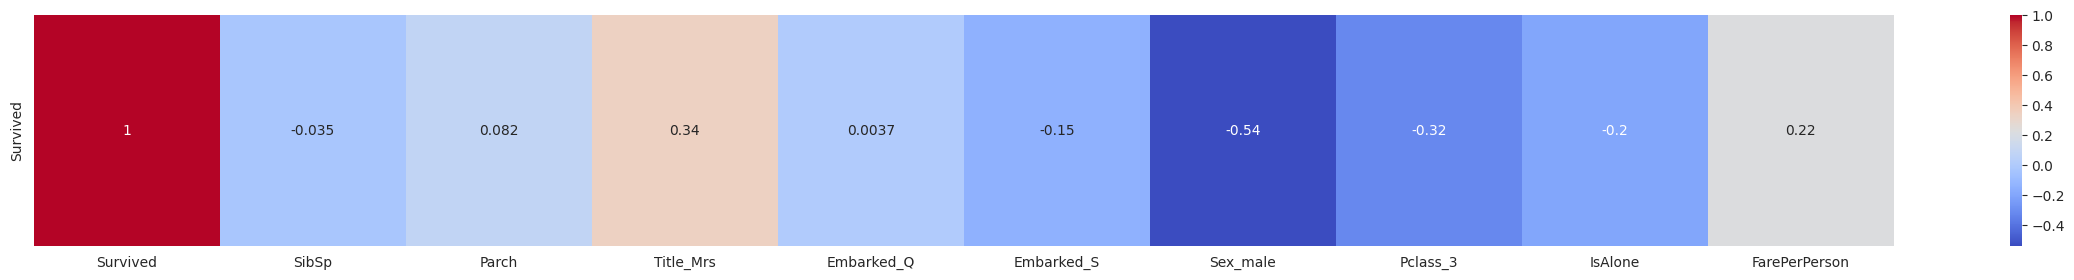

In [26]:
training_data.drop(['Title_Rare','FamilySize','Title_Mr','Pclass_2','Title_Miss'], axis=1, inplace=True)
test_data.drop(['Title_Rare','FamilySize','Title_Mr','Pclass_2','Title_Miss'], axis=1, inplace=True)
plt.figure(figsize=(30,3))
sns.heatmap(training_data.corr()[0:1],annot=True,cmap="coolwarm")

In [27]:
training_data.head()

,Survived,SibSp,Parch,Title_Mrs,Embarked_Q,Embarked_S,Sex_male,Pclass_3,IsAlone,FarePerPerson
0,0,1,0,0,0,1,1,1,0,3.62500
1,1,1,0,1,0,0,0,0,0,35.64165
2,1,0,0,0,0,1,0,1,1,7.92500
3,1,1,0,1,0,1,0,0,0,26.55000
4,0,0,0,0,0,1,1,1,1,8.05000


In [28]:
test_data.head()

,SibSp,Parch,Title_Mrs,Embarked_Q,Embarked_S,Sex_male,Pclass_3,IsAlone,FarePerPerson
0,0,0,0,1,0,1,1,1,7.829200
1,1,0,1,0,1,0,1,0,3.500000
2,0,0,0,1,0,1,0,1,9.687500
3,0,0,0,0,1,1,1,1,8.662500
4,1,1,1,0,1,0,1,0,4.095833


## Splitting Data

In [29]:
X_train = training_data.drop('Survived', axis=1)  # Features
y_train = training_data['Survived']  # Target
print(y_train.shape)
print(X_train.shape)
X_train.isnull().sum()

(891,)
(891, 9)


SibSp            0
Parch            0
Title_Mrs        0
Embarked_Q       0
Embarked_S       0
Sex_male         0
Pclass_3         0
IsAlone          0
FarePerPerson    0
dtype: int64

## Using LightGBM

In [30]:
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import numpy as np

# Define LightGBM model parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'device_type': 'cpu',  # Use CPU instead of GPU
    'boosting_type': 'gbdt',
    'num_leaves': 128,
    'learning_rate': 0.075,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'max_depth': 10,
    'verbose': -1
}

# Define function for k-fold cross-validation
def k_fold_cross_validation(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        train_data_fold = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_data_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data_fold)
        
        model_fold = lgb.train(params, train_data_fold, num_boost_round=1308, 
                               valid_sets=[val_data_fold], 
                               callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(50)])
        
        y_pred_prob = model_fold.predict(X_val_fold, num_iteration=model_fold.best_iteration)
        score = roc_auc_score(y_val_fold, y_pred_prob)
        scores.append(score)
    
    return scores

# Train LightGBM model
lgb_model = lgb.LGBMClassifier(**params)

# Perform k-fold cross-validation
cv_scores = k_fold_cross_validation(lgb_model, X_train, y_train, k=5)
print(f'Cross-validation ROC AUC scores: {cv_scores}')
print(f'Average cross-validation ROC AUC score: {np.mean(cv_scores):.4f}')

# Train on the full training data
lgb_model.fit(X_train, y_train)



Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.879151
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.811752
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.893122
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.833807
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.883867
Cross-validation ROC AUC scores: [0.8791505791505793, 0.8117520505580207, 0.8931216931216932, 0.8338068181818182, 0.883866575901974]
Average cross-validation ROC AUC score: 0.8603


LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, device_type='cpu',
               feature_fraction=0.8, lambda_l1=0.1, lambda_l2=0.1,
               learning_rate=0.075, max_depth=10, metric='auc', num_leaves=128,
               objective='binary', verbose=-1)

## predicting and Evaluating 

In [31]:
# Check columns in test_data
print(test_data.columns)

# Drop columns not used in the model (adjust according to actual column names)
columns_to_drop = ['PassengerId']  # Adjust this list as needed
existing_columns_to_drop = [col for col in columns_to_drop if col in test_data.columns]
test_features = test_data.drop(columns=existing_columns_to_drop)

# Predict
predictions = lgb_model.predict(test_features)

# Evaluate model using output_data (ground truth)
true_values = output_data['Survived']  # Ensure output_data is the correct DataFrame
accuracy = accuracy_score(true_values, predictions)
roc_auc = roc_auc_score(true_values, predictions)

# Print evaluation metrics
print(f"Model accuracy on test data: {accuracy*100:.4f}%")
print(f"Model roc_auc_score on test data: {roc_auc:.4f}")
print(confusion_matrix(true_values, predictions))


Index(['SibSp', 'Parch', 'Title_Mrs', 'Embarked_Q', 'Embarked_S', 'Sex_male',
       'Pclass_3', 'IsAlone', 'FarePerPerson'],
      dtype='object')
Model accuracy on test data: 87.5598%
Model roc_auc_score on test data: 0.8543
[[248  18]
 [ 34 118]]


## Saving Submission.csv

In [32]:
test_data_=pd.read_csv('/kaggle/input/titanic/test.csv')
output = pd.DataFrame({'PassengerId': test_data_.PassengerId, 'Survived':predictions})
output.to_csv('submission.csv', index=False)
x=pd.read_csv('submission.csv')

In [33]:
x.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## Conclusion Using LightGBM
In this project, we aimed to predict the survival of passengers on the Titanic using goven dataset. Our approach involved preprocessing the data, including handling missing values, one-hot encoding categorical features, and standardizing numerical features. We used LightGBM as our predictive model and employed standardization and an optimizer to enhance the model's performance and speed.

### Overall accuracy: 99.05%